In [30]:
import sys,os
sys.path.append(os.pardir)
import numpy as np
from numpy.random import *
from scipy import ceil, complex64, float64, hamming, zeros
from matplotlib import pylab as plt
import xml.etree.ElementTree as et
import argparse
import time
from cmf.crmf import CRMF
from cmf.scipy_crmf import ScipyCRMF
from matplotlib import pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [31]:
method_name_small = 'cmf'
method_name_capital = 'CMF'
experiment_name = 'estimation_5'
parser = argparse.ArgumentParser(description='structure detection test')
parser.add_argument('-s', '--seed_number', \
                    action='store', \
                    nargs='?', \
                    const=None, \
                    default=0, \
                    type=int, \
                    choices=None, \
                    help='seed_number', \
                    metavar=None)
parser.add_argument('-d', '--dat_dir', \
                    action='store', \
                    nargs='?', \
                    const=None, \
                    default='../dat/estimation', \
                    type=str, \
                    choices=None, \
                    help='Directory where npy files will be stored.', \
                    metavar=None)
parser.add_argument('-n', '--dat_npz', \
                    action='store', \
                    nargs='?', \
                    const=None, \
                    default=method_name_small+'_'+experiment_name+'_'+time.strftime('%Y%m%d%H%M')+'.npz', \
                    type=str, \
                    choices=None, \
                    help='npz file name', \
                    metavar=None)
parser.add_argument('-png', '--dat_png', \
                    action='store', \
                    nargs='?', \
                    const=None, \
                    default=method_name_small+'_'+experiment_name+'_'+time.strftime('%Y%m%d%H%M')+'.png', \
                    type=str, \
                    choices=None, \
                    help='png file name', \
                    metavar=None)
parser.add_argument('-pdf', '--dat_pdf', \
                    action='store', \
                    nargs='?', \
                    const=None, \
                    default=method_name_small+'_'+experiment_name+'_'+time.strftime('%Y%m%d%H%M')+'.pdf', \
                    type=str, \
                    choices=None, \
                    help='pdf file name', \
                    metavar=None)

_StoreAction(option_strings=['-pdf', '--dat_pdf'], dest='dat_pdf', nargs='?', const=None, default='cmf_estimation_5_201702241912.pdf', type=<class 'str'>, choices=None, help='pdf file name', metavar=None)

In [32]:
args = parser.parse_args([])

In [33]:
seed(args.seed_number)


In [34]:
n_tests = 1
n_criteria = 5
n_samples_list = [100, 300, 1000, 3000]
n_samples_for_transfer = 200
data_dim = 12
convolution_width = 5
true_n_components_list = [2, 4]
base_SD = 10000.0 * np.ones([data_dim])
noise_SD = 1.0 * np.ones([data_dim])
activation_laprace_scale = 0.01 
loop_max = 10000
convergence_threshold = 0.0001

In [35]:
aux_joint_loss_transition = np.float("nan") * np.ones([len(true_n_components_list), len(n_samples_list), 2 * loop_max])
scipy_joint_loss_transition = np.float("nan") * np.ones([len(true_n_components_list), len(n_samples_list), 2 * loop_max])
transfer_joint_loss_transition = np.float("nan") * np.ones([len(true_n_components_list), len(n_samples_list), loop_max])
aux_elapsed_time = np.float("nan") * np.ones([len(true_n_components_list), len(n_samples_list), 2 * loop_max])
scipy_elapsed_time = np.float("nan") * np.ones([len(true_n_components_list), len(n_samples_list), 2 * loop_max])
transfer_elapsed_time = np.float("nan") * np.ones([len(true_n_components_list), len(n_samples_list), loop_max])

(2, 4)
n_samples 100
(100, 2) (5, 2, 12)
n_samples 300
(300, 2) (5, 2, 12)
n_samples 1000
(1000, 2) (5, 2, 12)
n_samples 3000
(3000, 2) (5, 2, 12)
n_samples 100
(100, 4) (5, 4, 12)
n_samples 300
(300, 4) (5, 4, 12)
n_samples 1000
(1000, 4) (5, 4, 12)
n_samples 3000
(3000, 4) (5, 4, 12)


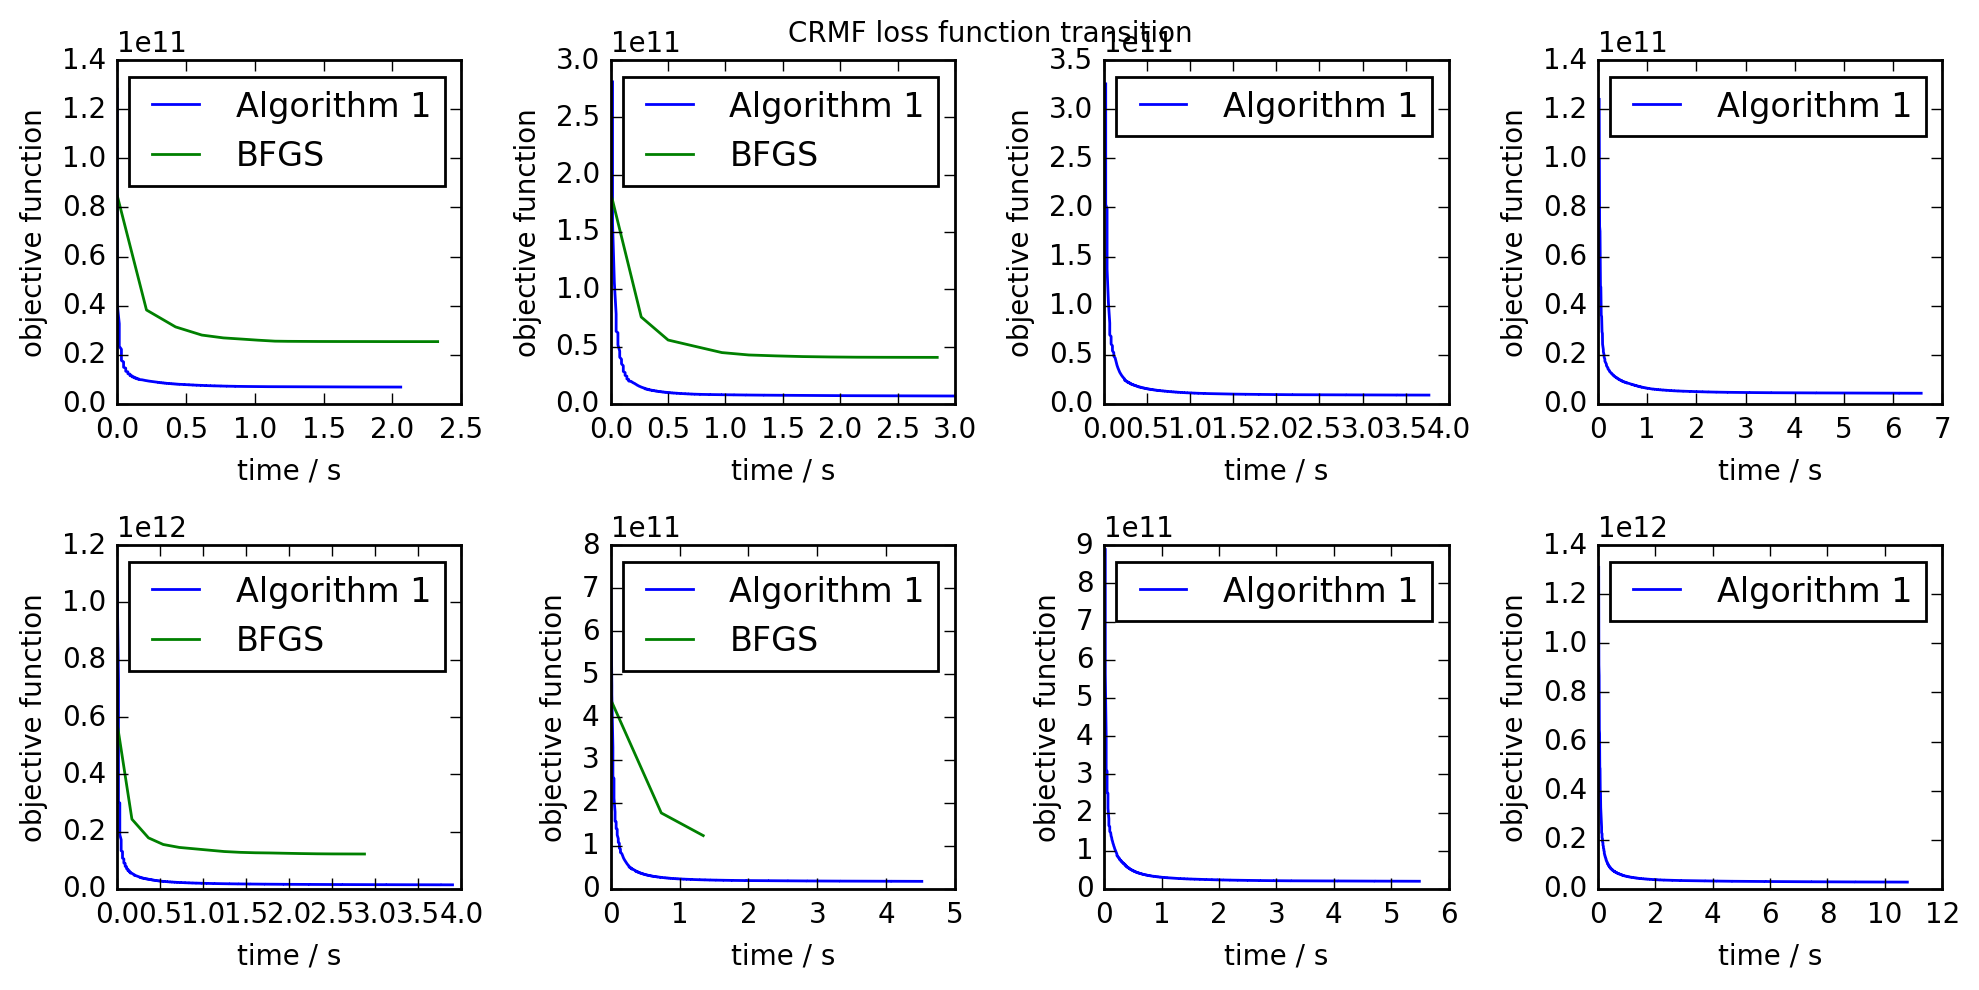

In [36]:
# %pdb
# import warnings
# warnings.filterwarnings('error')
fig, ax = plt.subplots(nrows=len(true_n_components_list), ncols=len(n_samples_list), figsize=(10,5))
print(ax.shape)
xlabel = 'time / s'
ylabel = 'objective function'
for i_n_components in range(len(true_n_components_list)):
    true_n_components = true_n_components_list[i_n_components]
    for i_n_samples in range(len(n_samples_list)):
        n_samples = n_samples_list[i_n_samples]
        print('n_samples', n_samples)
        true_activation = np.random.laplace(0, activation_laprace_scale, [n_samples, true_n_components])
        true_base = np.random.normal(0, base_SD[np.newaxis, np.newaxis, :], [convolution_width, true_n_components, data_dim])
        print(true_activation.shape, true_base.shape)
        X = np.random.normal(CRMF.convolute(true_activation, true_base), noise_SD)
        arg_dict = dict(
            convolution_max = convolution_width,
            component_max = X.shape[1],
            true_width = convolution_width,
            true_n_components = true_n_components,
            activation_l1_weight = 1.0 / activation_laprace_scale,
            activation_l2_weight = 0.0,
            convergence_threshold = convergence_threshold,
            loop_max = loop_max)
        loss_weight = 1.0 / (noise_SD * noise_SD)
        base_l2_weight = 1.0 / (base_SD * base_SD)
        base_l1_weight = 0.0 / np.mean(np.abs(X), axis=0)
        factorizer = CRMF(**arg_dict)
        filtre = np.ones(X.shape)
        factorizer.fit(X, None, filtre)
        aux_elapsed_time[i_n_components, i_n_samples, :] = factorizer.elapsed_time[convolution_width, true_n_components, :, :].reshape(loop_max * 2)
        aux_joint_loss_transition[i_n_components, i_n_samples, :] = factorizer.joint_loss_transition[convolution_width, true_n_components, :, :].reshape(loop_max * 2)/np.prod(X.shape)
        ax[i_n_components, i_n_samples].plot(aux_elapsed_time[i_n_components, i_n_samples, :], aux_joint_loss_transition[i_n_components, i_n_samples, :], label = 'Algorithm 1')
        factorizer = ScipyCRMF(**arg_dict)
        factorizer.fit(X, None, filtre)
        scipy_elapsed_time[i_n_components, i_n_samples, :] = factorizer.elapsed_time[convolution_width, true_n_components, :, :].reshape(loop_max * 2)
        scipy_joint_loss_transition[i_n_components, i_n_samples, :] = factorizer.joint_loss_transition[convolution_width, true_n_components, :, :].reshape(loop_max * 2)/np.prod(X.shape)
        if np.prod(np.isnan(scipy_joint_loss_transition[i_n_components, i_n_samples, :])) == 0:
            ax[i_n_components, i_n_samples].plot(scipy_elapsed_time[i_n_components, i_n_samples, :], scipy_joint_loss_transition[i_n_components, i_n_samples, :], label='BFGS')
#         true_activation_for_transfer = np.random.uniform(-base_max, base_max, [n_samples_for_transfer, true_n_components])
#         W = np.random.normal(CRMF.convolute(true_activation_for_transfer, true_base), 1.0)
#         transfer_filtre = np.ones(W.shape)
#         factorizer.transfer(W, None, transfer_filtre)
#         transfer_elapsed_time[i_n_components, i_n_samples, :] = factorizer.transfer_elapsed_time[convolution_width, true_n_components, :]
#         transfer_joint_loss_transition[i_n_components, i_n_samples, :] = factorizer.transfer_joint_loss_transition[convolution_width, true_n_components, :]
#         ax[i_n_components, i_n_samples].plot(transfer_elapsed_time[i_n_components, i_n_samples, :], transfer_joint_loss_transition[i_n_components, i_n_samples, :])
        ax[i_n_components, i_n_samples].set_xlabel(xlabel)
        ax[i_n_components, i_n_samples].set_ylabel(ylabel)
        ax[i_n_components, i_n_samples].legend()
fig.suptitle('CRMF loss function transition')
fig.tight_layout()
fig.savefig(args.dat_dir + '/' + args.dat_png, format='png')
fig.savefig(args.dat_dir + '/' + args.dat_pdf, format='pdf')


(2, 4)


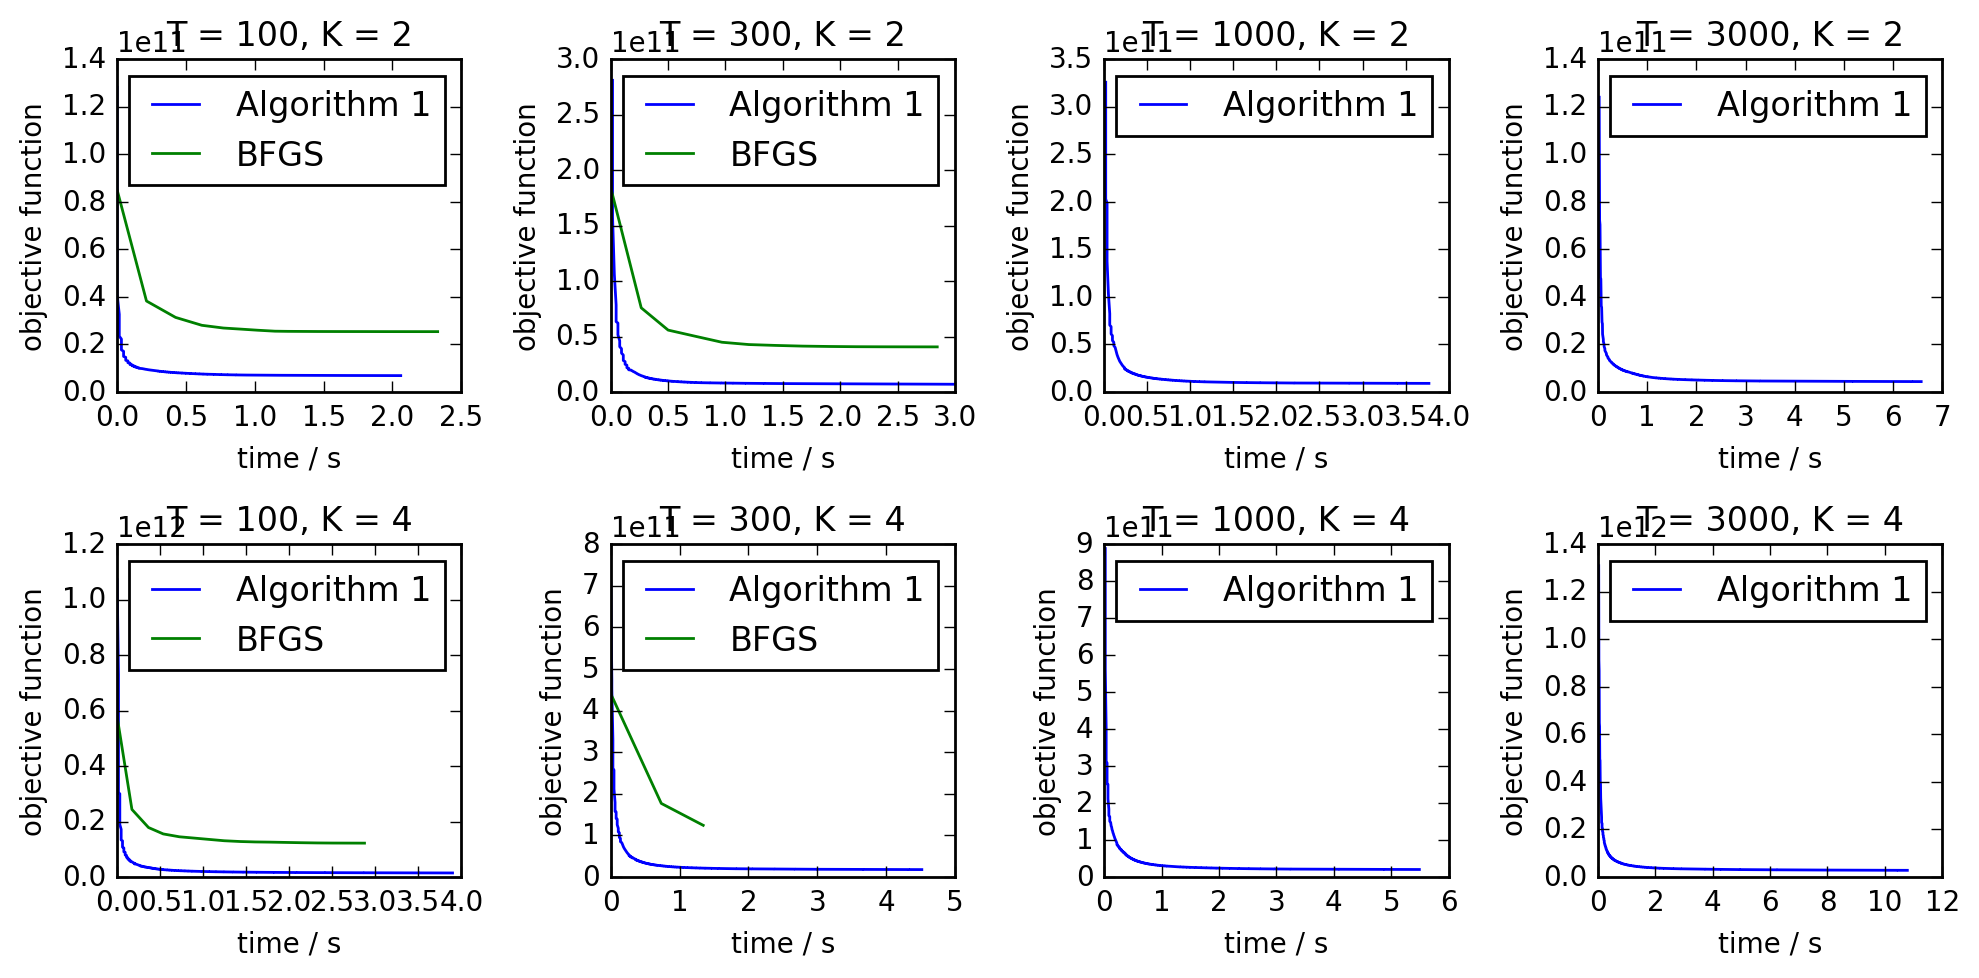

In [38]:
fig, ax = plt.subplots(nrows=len(true_n_components_list), ncols=len(n_samples_list), figsize=(10,5))
print(ax.shape)
xlabel = 'time / s'
ylabel = 'objective function'
for i_n_components in range(len(true_n_components_list)):
    true_n_components = true_n_components_list[i_n_components]
    for i_n_samples in range(len(n_samples_list)):
        n_samples = n_samples_list[i_n_samples]
        ax[i_n_components, i_n_samples].plot(aux_elapsed_time[i_n_components, i_n_samples, :], aux_joint_loss_transition[i_n_components, i_n_samples, :], label = 'Algorithm 1')
        if np.prod(np.isnan(scipy_joint_loss_transition[i_n_components, i_n_samples, :])) == 0:
            ax[i_n_components, i_n_samples].plot(scipy_elapsed_time[i_n_components, i_n_samples, :], scipy_joint_loss_transition[i_n_components, i_n_samples, :], label='BFGS')
        ax[i_n_components, i_n_samples].set_xlabel(xlabel)
        ax[i_n_components, i_n_samples].set_ylabel(ylabel)
        ax[i_n_components, i_n_samples].title.set_text('T = '+str(n_samples)+', K = '+str(true_n_components))
        ax[i_n_components, i_n_samples].legend()
# fig.suptitle('CRMF loss function transition', fontsize = 16)
fig.tight_layout()
fig.savefig(args.dat_dir + '/' + args.dat_png, format='png')
fig.savefig(args.dat_dir + '/' + args.dat_pdf, format='pdf')


In [37]:
np.savez(args.dat_dir + '/' + args.dat_npz,
         aux_joint_loss_transition = aux_joint_loss_transition,
         scipy_joint_loss_transition = scipy_joint_loss_transition,
         aux_elapsed_time = aux_elapsed_time,
         scipy_elapsed_time = scipy_elapsed_time,
         n_samples_list = n_samples_list,
         true_n_components_list = true_n_components_list,
         convolution_width = convolution_width)


In [9]:
# npz = np.load(args.dat_dir + '/artificial_result_201701210117.npz')

Automatic pdb calling has been turned ON
(2, 4)


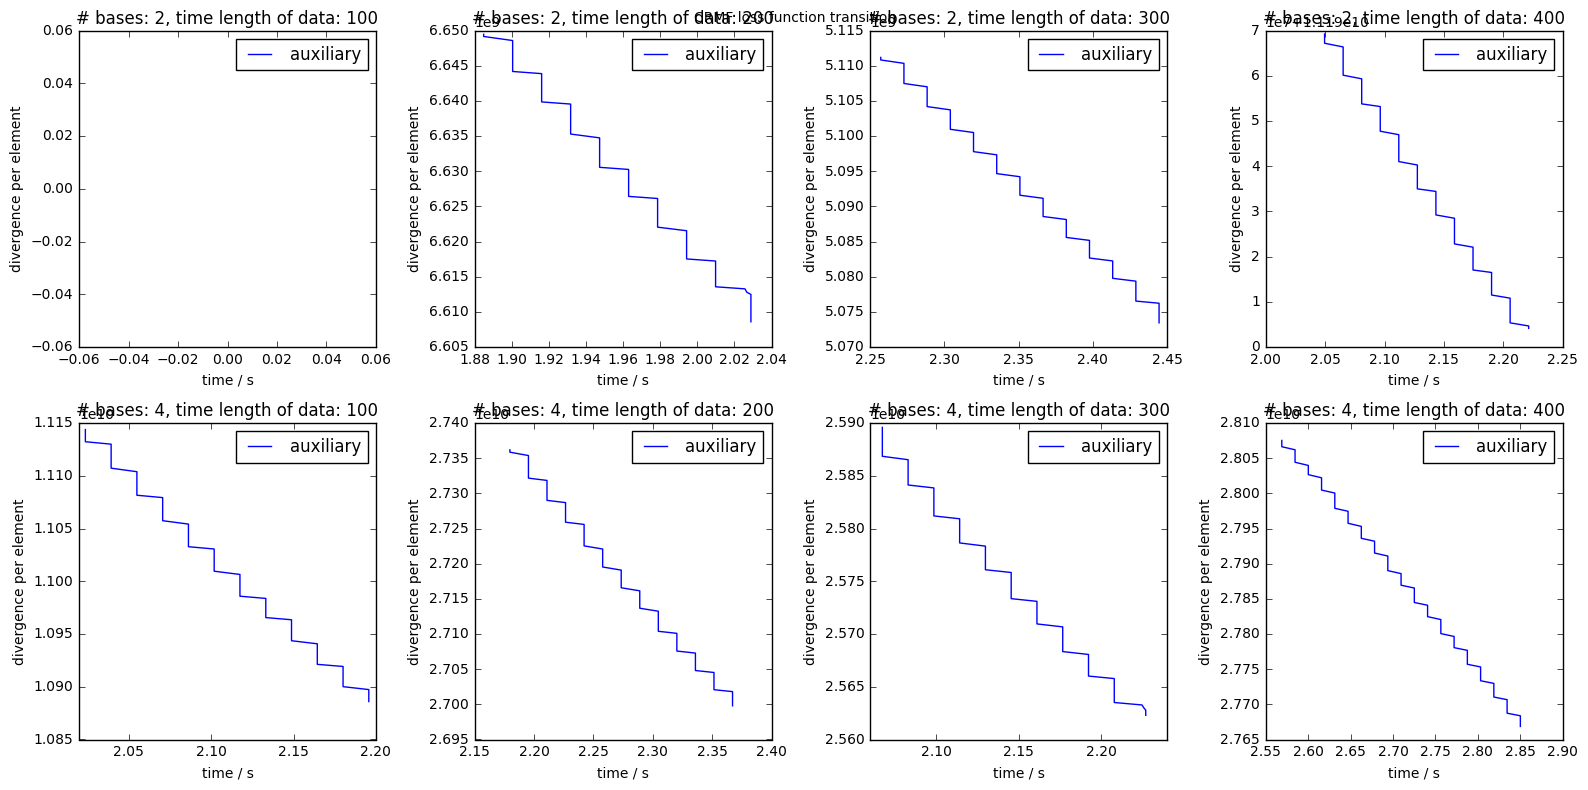

In [10]:
%pdb
import warnings
warnings.filterwarnings('error')
fig, ax = plt.subplots(nrows=len(true_n_components_list), ncols=len(n_samples_list), figsize=(16,8))
print(ax.shape)
xlabel = 'time / s'
ylabel = 'divergence per element'
plot_start = 900
plot_end = 1000
for i_n_components in range(len(true_n_components_list)):
    true_n_components = true_n_components_list[i_n_components]
    for i_n_samples in range(len(n_samples_list)):
        n_samples = n_samples_list[i_n_samples]
        ax[i_n_components, i_n_samples].plot(aux_elapsed_time[i_n_components, i_n_samples, plot_start:plot_end], aux_joint_loss_transition[i_n_components, i_n_samples, plot_start:plot_end], label='auxiliary')
#         if np.prod(np.isnan(scipy_joint_loss_transition[i_n_components, i_n_samples, :])) == 0:
#             ax[i_n_components, i_n_samples].plot(scipy_elapsed_time[i_n_components, i_n_samples, plot_start:plot_end], scipy_joint_loss_transition[i_n_components, i_n_samples, plot_start:plot_end], label='Scipy')
        ax[i_n_components, i_n_samples].set_xlabel(xlabel)
        ax[i_n_components, i_n_samples].set_ylabel(ylabel)
        ax[i_n_components, i_n_samples].set_title('# bases: '+str(true_n_components)+', time length of data: '+str(n_samples))
        ax[i_n_components, i_n_samples].legend()
fig.suptitle('CRMF loss function transition')
fig.tight_layout()
fig.savefig(args.dat_dir + '/' + args.dat_png, format='png')

In [11]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.
